In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import MulensModel as mm
from scipy.stats import norm, gamma
import emcee
import corner

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

In [3]:
path = "/Users/nunotahiroshisuke/Desktop/iral/work/mulens/MulensModel-master/data/photometry_files/OB05086/starBLG234.6.I.218982.dat"
data = mm.MulensData(file_name=path, add_2450000=True)

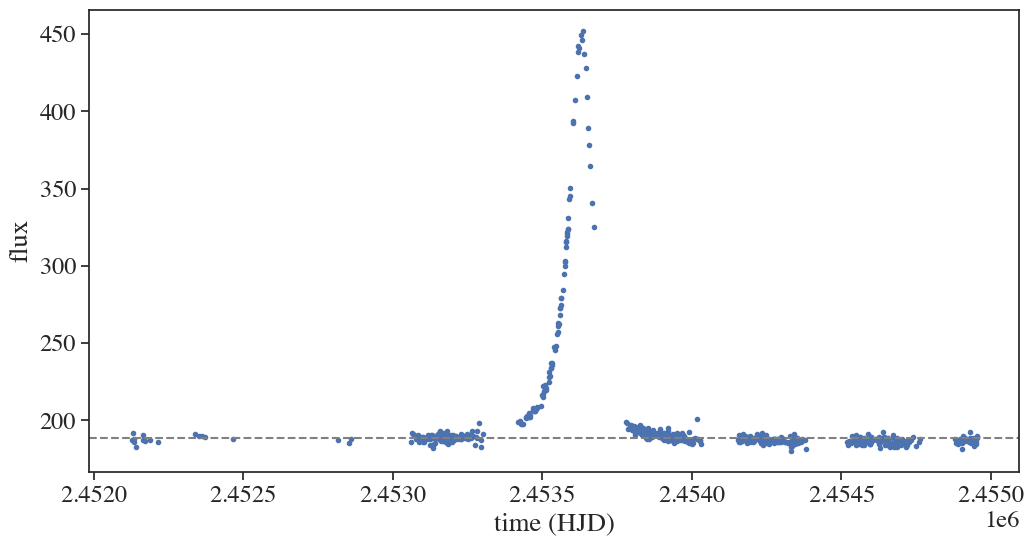

In [4]:
plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed')

plt.show()

In [5]:
def calc_A(t0, tE, u0, t):
    u = np.sqrt(u0**2 + ((t-t0)/tE)**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2+4))
    return A

def calc_f(t0,tE,u0,f_base,f_ratio,t): 
    fb = f_base * f_ratio
    fs = f_base - fb 
    A = calc_A(t0,tE,u0,t)
    return A * fs + fb

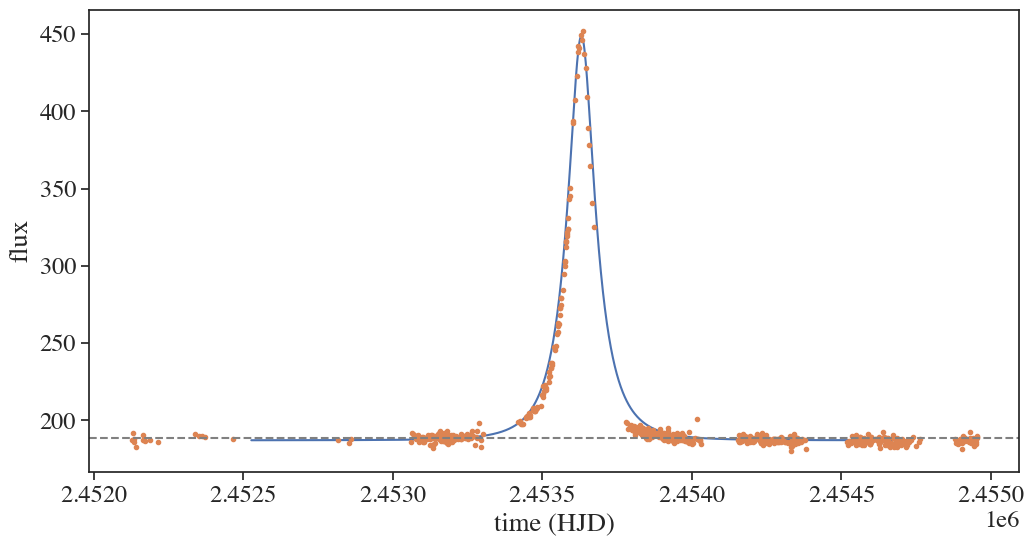

In [6]:
t0 = 2453630.69
tE = 110.35
u0 = 0.42
f_base = 187.17
f_ratio = 0.09
t_plot = np.linspace(t0-10*tE,t0+10*tE,1000)
f_plot = calc_f(t0,tE,u0,f_base,f_ratio,t_plot)

plt.plot(t_plot,f_plot)

plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed')


plt.show()

In [7]:
kappa = 8.144; #mas /M_sun
def phys2mic(ML,DL,DS,murel): #M_sun, kpc, kpc, mas/year 
    pi_rel = 1/DL - 1/DS
    thE = np.sqrt(kappa*ML*pi_rel) #mas
    tE = thE / murel * 365.25 #day

    return tE

def calc_f_phys(t0,u0,f_base,f_ratio,ML,DL,DS,murel,t): 
    tE = phys2mic(ML,DL,DS,murel)
    fb = f_base * f_ratio
    fs = f_base - fb 
    A = calc_A(t0,tE,u0,t)
    return A * fs + fb

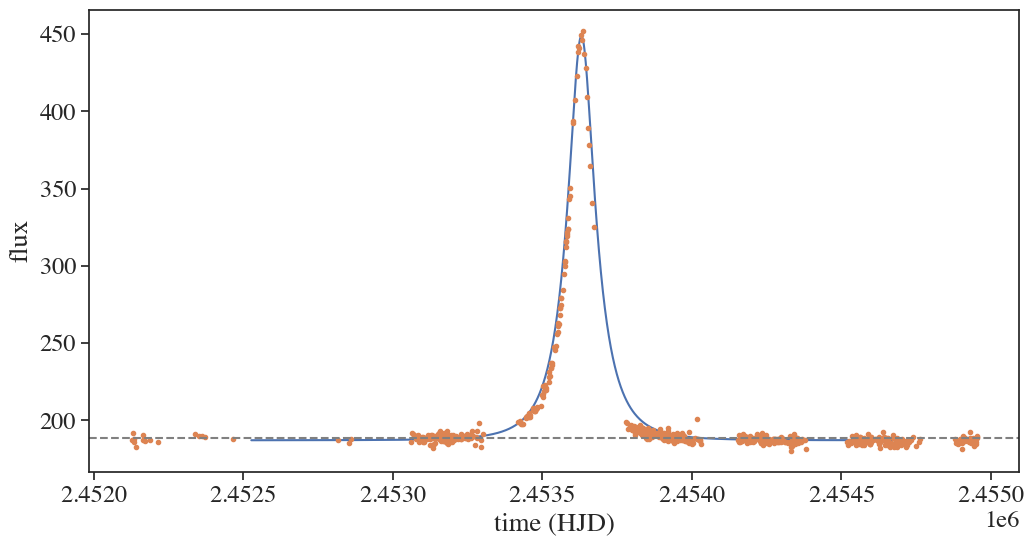

In [8]:
ML = 1
DL = 6
DS = 8
murel = 1.928107077287133
t_plot = np.linspace(t0-10*tE,t0+10*tE,1000)
f_plot = calc_f_phys(t0,u0,f_base,f_ratio,ML,DL,DS,murel,t_plot)

plt.plot(t_plot,f_plot)

plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed')


plt.show()

In [9]:
def calc_chi2(t0,u0,f_base,f_ratio,ML,DL,DS,murel):
    f_model = calc_f_phys(t0,u0,f_base,f_ratio,ML,DL,DS,murel,data.time)
    chi2 = np.sum(((f_model - data.flux)/ data.err_flux)**2)
    return chi2

def ln_prior(t0, u0, f_base, f_ratio, log10_ML, DL, DS, murel):
    if not (2453000 <= t0 <= 2455000):
        return -np.inf
    if not (0 <= u0 <= 5):
        return -np.inf
    if not (150 <= f_base <= 250):
        return -np.inf
    if not (0 <= f_ratio <= 1):
        return -np.inf
    if not (-2 <= log10_ML <= 1):
        return -np.inf

    if DL >= DS or murel <= 0 or not (0 < DL < 12):
        return -np.inf

    x = 12 - DL 
    ln_prior_DL = gamma(a=9.0, scale=0.6667).logpdf(x)
    ln_prior_murel = gamma(a=8.0, scale=1.0).logpdf(murel)
    ln_prior_DS = norm(loc=8.0, scale=0.5).logpdf(DS)

    return ln_prior_DL + ln_prior_DS + ln_prior_murel

def ln_pos(theta):
    t0, u0, f_base, f_ratio, log10_ML, DL, DS, murel = theta

    ML = 10 ** log10_ML

    lp = ln_prior(t0, u0, f_base, f_ratio, log10_ML, DL, DS, murel)
    if not np.isfinite(lp):
        return -np.inf

    ll = -0.5 * calc_chi2(t0, u0, f_base, f_ratio, ML, DL, DS, murel)
    if not np.isfinite(ll):
        return -np.inf

    return lp + ll

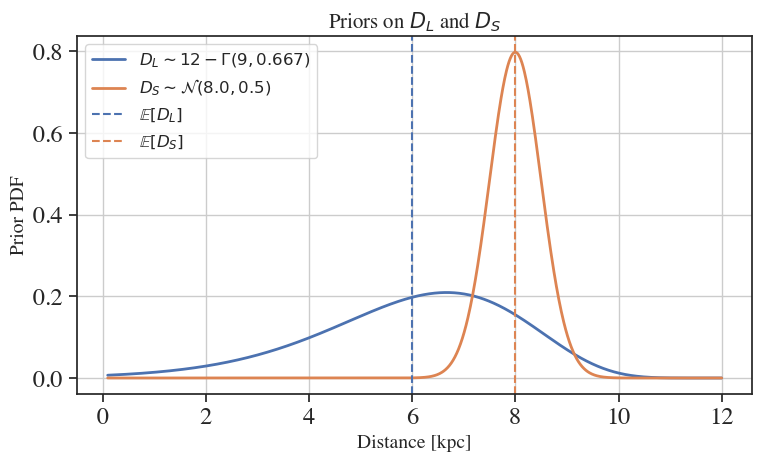

In [10]:
k_DL = 9.0
theta_DL = 0.6667
DL_max = 12.0

mu_DS = 8.0
sigma_DS = 0.5

x = np.linspace(0.1, 12.0, 1000)

x_gamma = DL_max - x
pdf_DL = gamma.pdf(x_gamma, a=k_DL, scale=theta_DL)

pdf_DS = norm.pdf(x, loc=mu_DS, scale=sigma_DS)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf_DL, label=r"$D_L \sim 12 - \Gamma(9, 0.667)$", color="C0", lw=2)
plt.plot(x, pdf_DS, label=r"$D_S \sim \mathcal{N}(8.0, 0.5)$", color="C1", lw=2)

plt.axvline(DL_max - gamma.mean(k_DL, scale=theta_DL), color="C0", linestyle="--", label=r"$\mathbb{E}[D_L]$")
plt.axvline(mu_DS, color="C1", linestyle="--", label=r"$\mathbb{E}[D_S]$")

plt.xlabel("Distance [kpc]", fontsize=14)
plt.ylabel("Prior PDF", fontsize=14)
plt.title("Priors on $D_L$ and $D_S$", fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


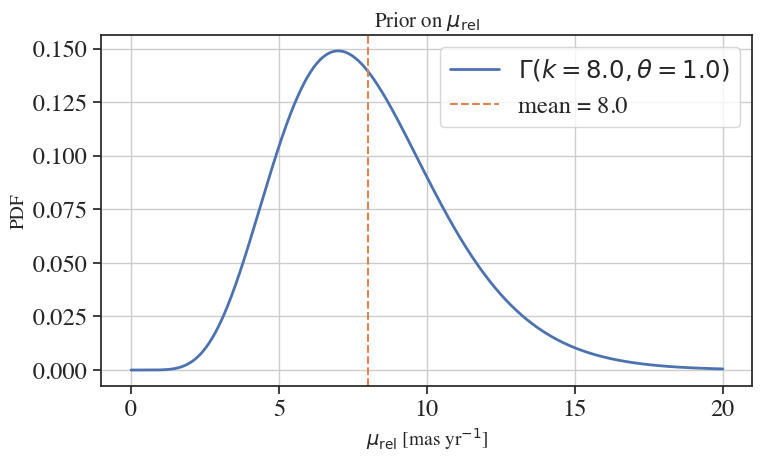

In [11]:
k = 8.0       # shape
theta = 1.0   # scale
mean = k * theta  # = 8

x = np.linspace(0.001, 20, 1000)
pdf = gamma.pdf(x, a=k, scale=theta)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label=fr"$\Gamma(k={k}, \theta={theta})$", color="C0", lw=2)
plt.axvline(mean, color="C1", linestyle="--", label=f"mean = {mean:.1f}")
plt.xlabel(r"$\mu_{\rm rel}$ [mas yr$^{-1}$]", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.title("Prior on $\\mu_{\\rm rel}$", fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
#tEを固定して、DL,DS,murelを事前分布からサンプリングし、固定したtEを再現するようなMLを探す。
#それをmcmcの初期値とする

nwalkers = 32
target_tE = 110.35
tolerance = 0.5
ndim = 8
rng = np.random.default_rng(seed=42)

init_obs_params = np.array([t0, u0, f_base, f_ratio])
step_size_obs   = np.array([0.05,0.01,1.0,0.01])

p0_all = []

while len(p0_all) < nwalkers:
    obs_sample = init_obs_params + step_size_obs * rng.normal(size=4)

    t0, u0, f_base, f_ratio = obs_sample
    f_ratio = np.clip(f_ratio, 0, 1)

    x = gamma.rvs(a=9.0, scale=0.6667, random_state=rng)
    DL = 12.0 - x
    if not (0 < DL < 12.0):
        continue

    DS = rng.normal(loc=8.0, scale=0.5)
    if DS <= DL:
        continue

    murel = rng.gamma(8.0, 1.0)

    for _ in range(20):
        log10_ML = rng.uniform(-2, 1)
        ML = 10**log10_ML
        tE = phys2mic(ML, DL, DS, murel)
        if abs(tE - target_tE) < tolerance:
            full_param = [t0, u0, f_base, f_ratio, log10_ML, DL, DS, murel]
            p0_all.append(full_param)
            break

p0_all = np.array(p0_all)  # shape: (nwalkers, ndim)


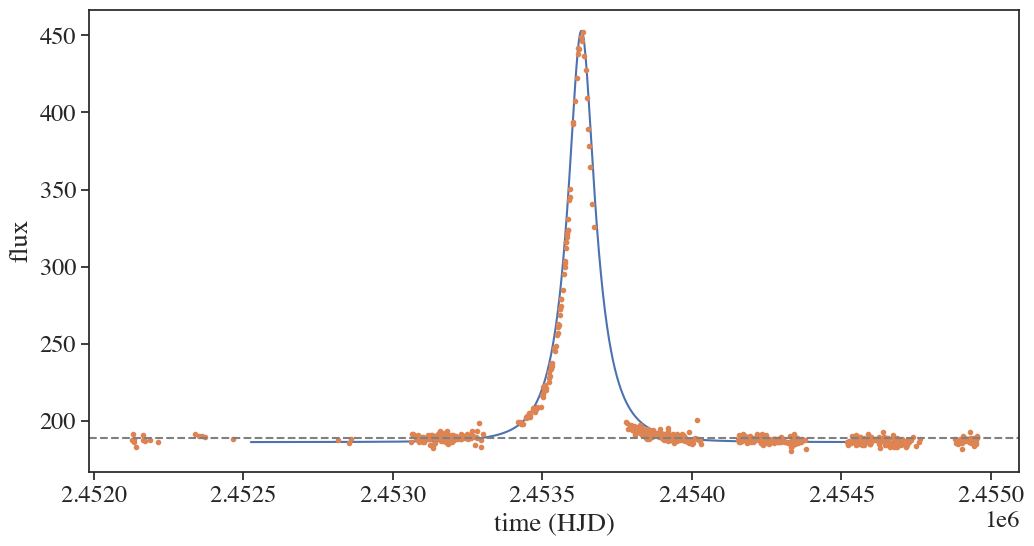

In [13]:
t_plot = np.linspace(t0-10*tE,t0+10*tE,1000)
t0_test,u0_test,f_base_test,f_ratio_test,log10ML_test,DL_test,DS_test,murel_test = p0_all[10]
ML_test = 10**log10ML_test
f_plot = calc_f_phys(t0_test,u0_test,f_base_test,f_ratio_test,ML_test,DL_test,DS_test,murel_test,t_plot)

plt.plot(t_plot,f_plot)

plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed')


plt.show()

In [14]:
ndim = 8
nwalkers = len(p0_all)
nsteps = 5000  

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pos)

sampler.run_mcmc(p0_all, nsteps, progress=True)

100%|██████████| 5000/5000 [02:19<00:00, 35.93it/s]


State([[2.45362821e+06 3.84711732e-01 1.87130946e+02 1.97360400e-01
  8.36791084e-01 6.22453738e+00 8.37433694e+00 5.53374025e+00]
 [2.45362818e+06 3.63789636e-01 1.87081044e+02 2.54647609e-01
  4.38345340e-01 5.53008550e+00 7.51878230e+00 3.64069736e+00]
 [2.45362844e+06 3.83543171e-01 1.87147829e+02 2.01243936e-01
  2.50169681e-01 5.16222507e+00 8.17425665e+00 3.69277825e+00]
 [2.45362839e+06 3.67636110e-01 1.87012304e+02 2.43842672e-01
  1.34692439e-01 2.82151879e+00 8.27217494e+00 5.67250015e+00]
 [2.45362818e+06 3.65417242e-01 1.87163227e+02 2.46075398e-01
  6.76841901e-01 6.11448125e+00 7.82231224e+00 4.17785500e+00]
 [2.45362835e+06 3.70172822e-01 1.87044548e+02 2.34174908e-01
  9.46277630e-01 4.70711183e+00 8.30355786e+00 9.16413058e+00]
 [2.45362834e+06 3.74199951e-01 1.87002599e+02 2.23937731e-01
  7.55248282e-01 4.77849330e+00 7.25014972e+00 6.48742755e+00]
 [2.45362851e+06 3.86733315e-01 1.87102947e+02 1.92095074e-01
  2.09883629e-01 3.84422611e+00 8.69870380e+00 5.03058447

In [15]:
samples = sampler.get_chain(flat=True,discard=1000,thin=50)
poss = sampler.get_log_prob(flat=True,discard=1000,thin=50)

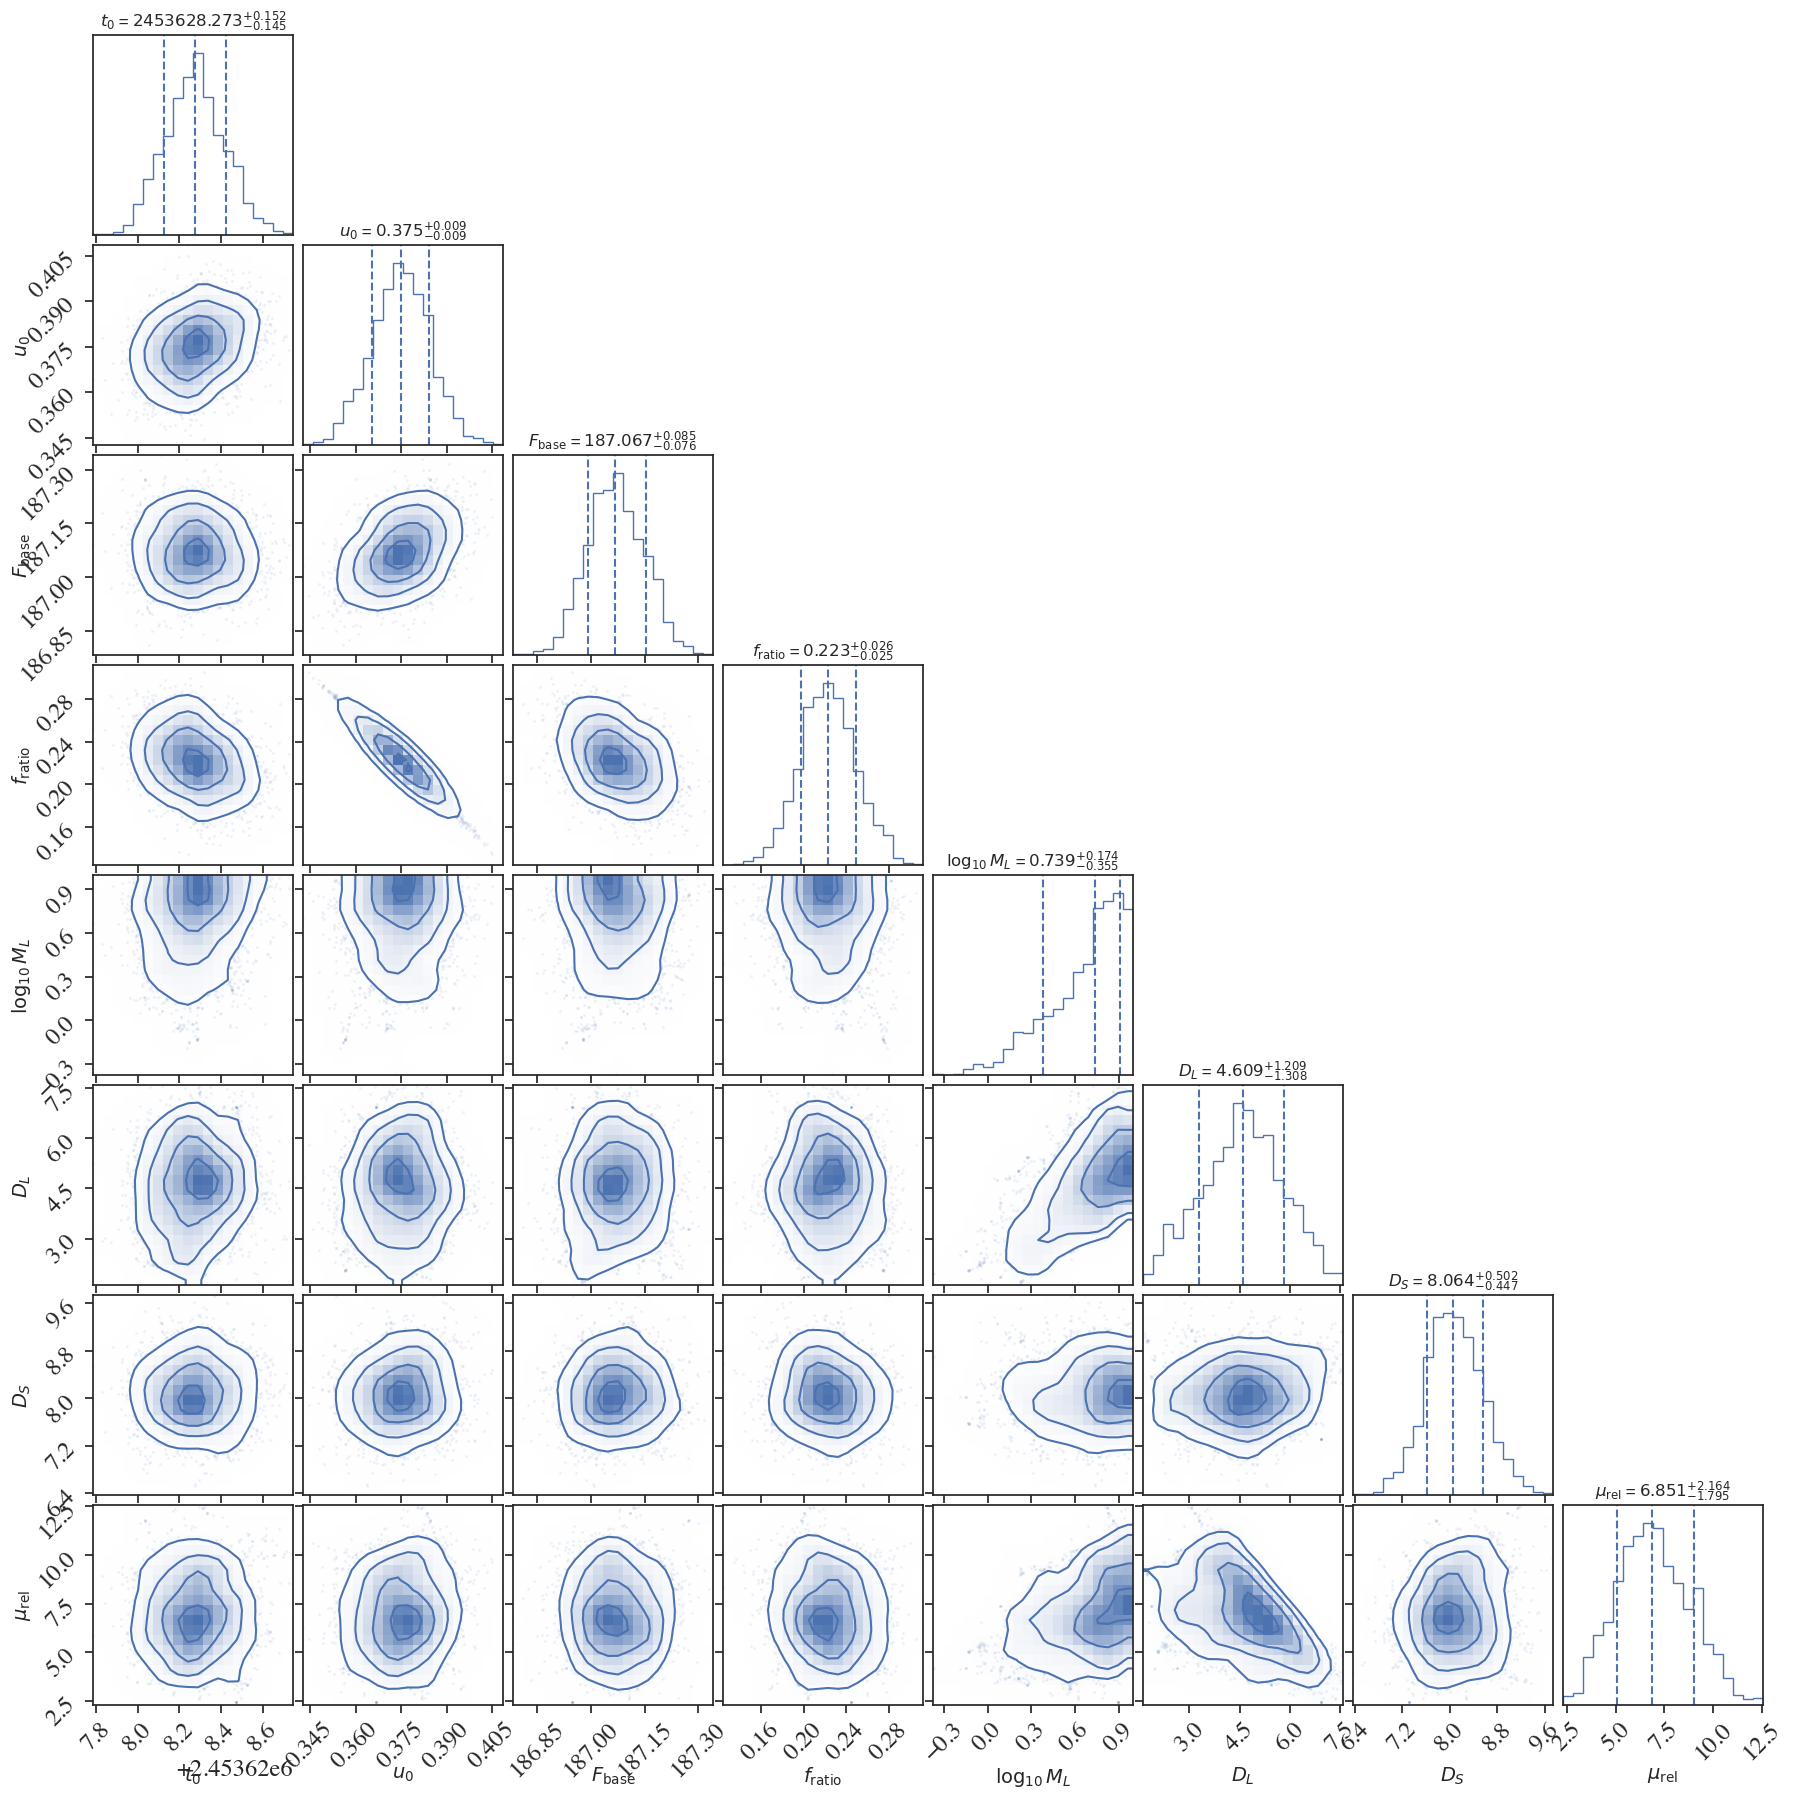

In [16]:
labels = [
    r"$t_0$", r"$u_0$", r"$F_{\rm base}$", r"$f_{\rm ratio}$",
    r"$\log_{10} M_L$", r"$D_L$", r"$D_S$", r"$\mu_{\rm rel}$"
]

fig = corner.corner(
    samples, 
    labels=labels,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    
    smooth=1.0,
    color="C0"
)

plt.show()


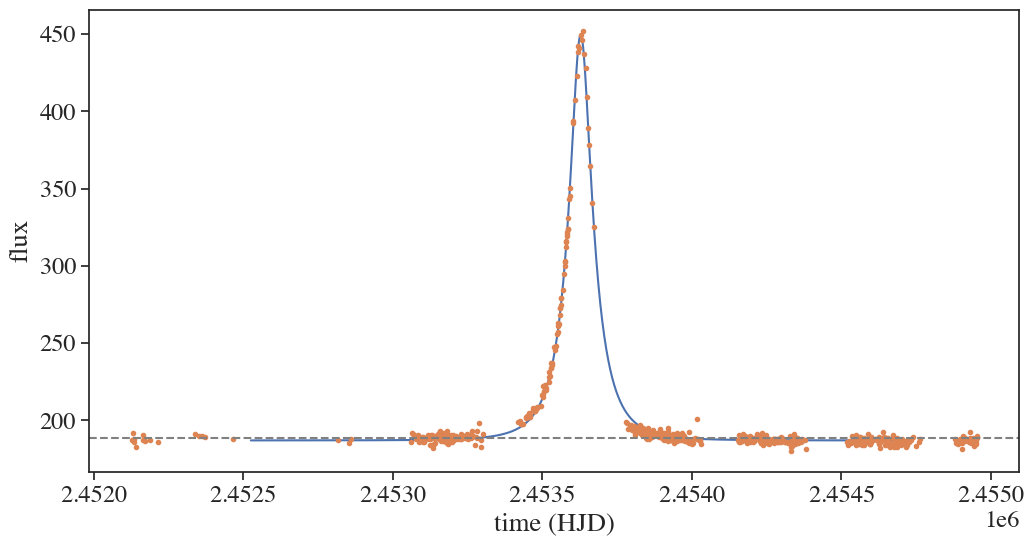

In [18]:
t_plot = np.linspace(t0-10*tE,t0+10*tE,1000)
t0_test,u0_test,f_base_test,f_ratio_test,log10ML_test,DL_test,DS_test,murel_test = samples[np.argmax(poss)]
ML_test = 10**log10ML_test
f_plot = calc_f_phys(t0_test,u0_test,f_base_test,f_ratio_test,ML_test,DL_test,DS_test,murel_test,t_plot)

plt.plot(t_plot,f_plot)

plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed')

plt.show()